# Hybrid Recommendation System: Combine Collaborative & Content based 

In [1]:
!python -V

Python 3.8.5


In [38]:
#importing required libs
#data tools
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

#viz
import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

#cleaning & preprocessing
import re
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import pickle
from scipy.stats import tmean, scoreatpercentile
from ast import literal_eval

# 1. Data Reading,Preprocessing, EDA

### Load News Data

In [4]:
platform_content = pd.read_csv("../data/platform_content.csv")

In [5]:
platform_content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [6]:
consumer_transanctions = pd.read_csv('../data/consumer_transanctions.csv')

/Users/ganesh/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
consumer_transanctions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [8]:
consumer_transanctions.columns

Index(['event_timestamp', 'interaction_type', 'item_id', 'consumer_id',
       'consumer_session_id', 'consumer_device_info', 'consumer_location',
       'country'],
      dtype='object')

In [9]:
consumer_transanctions.interaction_type.value_counts()#.isna().sum()

content_watched         61086
content_liked            5745
content_saved            2463
content_commented_on     1611
content_followed         1407
Name: interaction_type, dtype: int64

In [10]:
#Ratings
map_ = {'content_followed':5,'content_commented_on':4,'content_saved':3,'content_liked':2,'content_watched':1}
consumer_interactions = consumer_transanctions
consumer_interactions['rating'] = consumer_interactions['interaction_type'].apply(lambda x:map_[x])
consumer_interactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,rating
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,5
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,1


In [11]:
#pick required cols
consumer_interactions = consumer_interactions[['interaction_type','item_id', 'consumer_id','rating','consumer_device_info', 'consumer_location']]


In [12]:
consumer_interactions.head()

,interaction_type,item_id,consumer_id,rating,consumer_device_info,consumer_location
0,content_watched,-3499919498720038879,-8845298781299428018,1,NaN,NaN
1,content_watched,8890720798209849691,-1032019229384696495,1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY
2,content_watched,310515487419366995,-1130272294246983140,1,NaN,NaN
3,content_followed,310515487419366995,344280948527967603,5,NaN,NaN
4,content_watched,-7820640624231356730,-445337111692715325,1,NaN,NaN


In [13]:
consumer_interactions.isna().sum()

interaction_type            0
item_id                     0
consumer_id                 0
rating                      0
consumer_device_info    15394
consumer_location       15405
dtype: int64

In [14]:
consumer_interactions.groupby('consumer_id').agg({'consumer_location':lambda x:len(set(x))})['consumer_location'].describe(percentiles=[0.45,0.5,0.85,0.9,.95])#==-1032019229384696495].isna().sum()


count    1895.000000
mean        1.897098
std         1.098846
min         1.000000
45%         2.000000
50%         2.000000
85%         2.000000
90%         3.000000
95%         3.000000
max        21.000000
Name: consumer_location, dtype: float64

In [15]:
consumer_interactions.shape

(72312, 6)

In [16]:
consumer_interactions.nunique()

interaction_type           5
item_id                 2987
consumer_id             1895
rating                     5
consumer_device_info    1090
consumer_location         71
dtype: int64

In [18]:
consumer_interactions.dtypes

interaction_type        object
item_id                  int64
consumer_id              int64
rating                   int64
consumer_device_info    object
consumer_location       object
dtype: object

In [68]:
consumer_interactions.consumer_location.value_counts()[:20]

SP     40164
MG     10229
NY      1257
TX       923
GA       910
RJ       775
NJ       698
?        327
CA       238
ON       202
NSW      135
IL       113
13       107
PR        88
MI        84
PA        76
FL        49
MA        39
49        39
ES        32
Name: consumer_location, dtype: int64

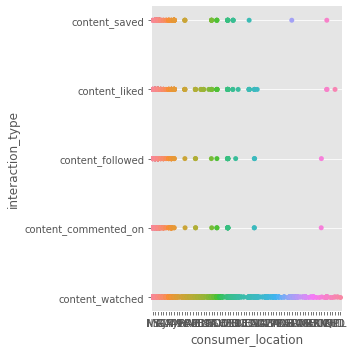

In [64]:
sns.catplot(x='consumer_location',y='interaction_type',data=consumer_interactions)

In [70]:
# sns.catplot(x='consumer_device_info',y='interaction_type',data=consumer_interactions)

## Create Ratings Data

In [71]:
ratings = consumer_interactions[['consumer_id','item_id','rating']]

In [72]:
ratings.head()

,consumer_id,item_id,rating
0,-8845298781299428018,-3499919498720038879,1
1,-1032019229384696495,8890720798209849691,1
2,-1130272294246983140,310515487419366995,1
3,344280948527967603,310515487419366995,5
4,-445337111692715325,-7820640624231356730,1


In [74]:
ratings.nunique()

consumer_id    1895
item_id        2987
rating            5
dtype: int64

In [75]:
ratings.shape

(72312, 3)

In [76]:
ratings.head()

,consumer_id,item_id,rating
0,-8845298781299428018,-3499919498720038879,1
1,-1032019229384696495,8890720798209849691,1
2,-1130272294246983140,310515487419366995,1
3,344280948527967603,310515487419366995,5
4,-445337111692715325,-7820640624231356730,1


In [77]:
ratings.describe()

,consumer_id,item_id,rating
count,7.231200e+04,7.231200e+04,72312.000000
mean,1.252026e+16,-3.033423e+16,1.292234
std,5.022333e+18,5.344755e+18,0.801325
min,-9.223122e+18,-9.222795e+18,1.000000
25%,-3.596627e+18,-4.726309e+18,1.000000
50%,-1.088422e+17,1.893099e+16,1.000000
75%,3.766319e+18,4.441012e+18,1.000000
max,9.210531e+18,9.222265e+18,5.000000


In [78]:
n_users = ratings.consumer_id.nunique()

n_items = ratings.item_id.nunique()

In [79]:
n_users

1895

In [80]:
n_items

2987

In [81]:
ratings.rating.value_counts()

1    61086
2     5745
3     2463
4     1611
5     1407
Name: rating, dtype: int64

<AxesSubplot:xlabel='rating', ylabel='Count'>

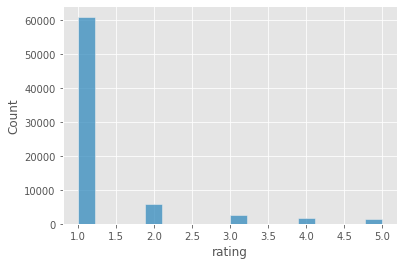

In [82]:
sns.histplot(ratings['rating'])

# 2. Collaborative Fitering: Item based Model

## Create Pivot Matrix from rating values

In [83]:
ratings = ratings.groupby(['consumer_id','item_id']).agg({'rating':'max'}).reset_index()

In [84]:
ratings.describe(percentiles=[0.25,0.5,0.75,0.8,0.85,0.9,0.95,.99])

,consumer_id,item_id,rating
count,4.071000e+04,4.071000e+04,40710.000000
mean,-3.994571e+16,-5.840552e+16,1.366839
std,5.107605e+18,5.375761e+18,0.895010
min,-9.223122e+18,-9.222795e+18,1.000000
25%,-3.954277e+18,-4.762898e+18,1.000000
50%,-8.938893e+16,-7.527881e+15,1.000000
75%,3.829785e+18,4.555339e+18,1.000000
80%,4.432373e+18,5.429923e+18,1.000000
85%,5.713241e+18,6.540624e+18,2.000000
90%,7.131994e+18,7.454602e+18,2.000000


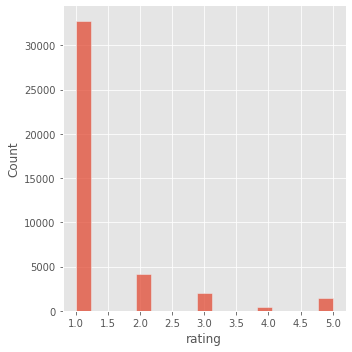

In [85]:
sns.displot(ratings['rating'])

In [86]:
data_matrix = ratings.pivot(
    index='consumer_id',
    columns='item_id',
    values='rating'
).fillna(0)

In [87]:
data_matrix.head()

item_id,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
consumer_id,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
data_matrix.shape

(1895, 2987)

# Pairwise Distance

## News pairwise similarity distance

In [89]:
data_matrix.T

consumer_id,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9150583489352258206,-9120685872592674274,...,9128735267433534024,9135582630122950040,9137372837662939523,9148269800512008413,9152852494775096912,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
item_id,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9216926795620865886,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9194572880052200111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9192549002213406534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9190737901804729417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213260650272029784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9215261273565326920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9217155070834564627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
data_matrix.T.shape

(2987, 1895)

In [91]:
# !pip install -U scikit-learn

In [92]:
from sklearn.metrics.pairwise import pairwise_distances 

In [93]:

item_similarity = 1- pairwise_distances(data_matrix.T, metric='cosine')


In [94]:
item_similarity

array([[1.        , 0.        , 0.        , ..., 0.36588087, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.06798894,
        0.05822225],
       ...,
       [0.36588087, 0.        , 0.        , ..., 1.        , 0.02901294,
        0.0745356 ],
       [0.        , 0.        , 0.06798894, ..., 0.02901294, 1.        ,
        0.07784989],
       [0.        , 0.        , 0.05822225, ..., 0.0745356 , 0.07784989,
        1.        ]])

In [95]:
item_similarity.shape

(2987, 2987)

## Get similar recommended news for a news_id

In [96]:
item_prediction = pd.DataFrame(item_similarity)

In [97]:
item_prediction.head()

,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,1.000000,0.0,0.000000,0.129358,0.207435,0.000000,0.0,0.231666,0.000000,0.000000,...,0.329293,0.400802,0.000000,0.736321,0.000000,0.000000,0.000000,0.365881,0.000000,0.000000
1,0.000000,1.0,0.000000,0.000000,0.000000,0.024398,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,1.000000,0.122743,0.000000,0.080354,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.122743,0.329355,0.073810,0.000000,0.067989,0.058222
3,0.129358,0.0,0.122743,1.000000,0.000000,0.109109,0.0,0.106600,0.117851,0.102062,...,0.000000,0.236682,0.083333,0.105409,0.277778,0.074536,0.044544,0.176777,0.143607,0.000000
4,0.207435,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.138013,0.000000,0.169031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [98]:
item_prediction.shape

(2987, 2987)

In [99]:
item_index = 10
item_prediction.iloc[item_index]

0       0.000000
1       0.000000
2       0.065094
3       0.294628
4       0.000000
          ...   
2982    0.000000
2983    0.000000
2984    0.000000
2985    0.000000
2986    0.000000
Name: 10, Length: 2987, dtype: float64

In [100]:
item_recommendation = pd.DataFrame(item_prediction.iloc[item_index].sort_values(ascending=False))

In [101]:
item_recommendation.head()

,10
10,1.00000
2032,0.57735
14,0.50000
1342,0.50000
1118,0.50000


In [102]:
ratings.iloc[10]['item_id']

-6545872007932025533

In [103]:
item_recommendation.reset_index(inplace=True)

In [104]:
item_recommendation.head()

,index,10
0,10,1.00000
1,2032,0.57735
2,14,0.50000
3,1342,0.50000
4,1118,0.50000


In [105]:
item_recommendation['item_id'] = item_recommendation['index'].apply(lambda x: ratings.iloc[x]['item_id'])

In [106]:
item_recommendation.head()

,index,10,item_id
0,10,1.00000,-6545872007932025533
1,2032,0.57735,1233935898842140014
2,14,0.50000,-4541461982704074404
3,1342,0.50000,1339353160969606996
4,1118,0.50000,6540624159201421051


In [107]:
item_recommendation.columns = ['index','score', 'item_id']

In [108]:
item_recommendation.head()

,index,score,item_id
0,10,1.00000,-6545872007932025533
1,2032,0.57735,1233935898842140014
2,14,0.50000,-4541461982704074404
3,1342,0.50000,1339353160969606996
4,1118,0.50000,6540624159201421051


In [109]:
item_recommendation.dtypes

index        int64
score      float64
item_id      int64
dtype: object

In [110]:
item_recommendation.describe()

,index,score,item_id
count,2987.000000,2987.000000,2.987000e+03
mean,1493.000000,0.032020,-1.688883e+17
std,862.416953,0.074261,5.411860e+18
min,0.000000,0.000000,-9.216927e+18
25%,746.500000,0.000000,-4.996337e+18
50%,1493.000000,0.000000,-1.331393e+17
75%,2239.500000,0.000000,4.434711e+18
max,2986.000000,1.000000,9.220446e+18


In [111]:
platform_content[platform_content['item_id']==ratings.iloc[item_index]['item_id']]['title']

2357    Why Silicon Valley is all wrong about Apple's ...
Name: title, dtype: object

### Merge item_id with news title

In [112]:
platform_content[['item_id','title']].head()

,item_id,title
0,-6451309518266745024,"Ethereum, a Virtual Currency, Enables Transact..."
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact..."
2,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...
3,-6151852268067518688,Google Data Center 360° Tour
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc..."


In [113]:
item_recommendation.head()

,index,score,item_id
0,10,1.00000,-6545872007932025533
1,2032,0.57735,1233935898842140014
2,14,0.50000,-4541461982704074404
3,1342,0.50000,1339353160969606996
4,1118,0.50000,6540624159201421051


In [114]:
item_recommendation.item_id.values[1] in (platform_content.item_id.values)

True

In [115]:
merged = pd.merge(item_recommendation, platform_content[['item_id','title']], on='item_id', how='left')

In [116]:
merged.head()

,index,score,item_id,title
0,10,1.00000,-6545872007932025533,Why Silicon Valley is all wrong about Apple's ...
1,2032,0.57735,1233935898842140014,Feito por Elas #01 Agnieszka Holland | AntiCast
2,14,0.50000,-4541461982704074404,Exclusive: Why Microsoft is betting its future...
3,1342,0.50000,1339353160969606996,Enable secure mode on your web product | Inter...
4,1118,0.50000,6540624159201421051,Bradesco vai lançar novo banco digital: o Next.


In [117]:
merged.shape

(3005, 4)

In [118]:
collab_output = merged[merged['title'].notna()]

In [119]:
collab_output.shape

(3005, 4)

In [120]:
collab_output.head(10)

,index,score,item_id,title
0,10,1.00000,-6545872007932025533,Why Silicon Valley is all wrong about Apple's ...
1,2032,0.57735,1233935898842140014,Feito por Elas #01 Agnieszka Holland | AntiCast
2,14,0.50000,-4541461982704074404,Exclusive: Why Microsoft is betting its future...
3,1342,0.50000,1339353160969606996,Enable secure mode on your web product | Inter...
4,1118,0.50000,6540624159201421051,Bradesco vai lançar novo banco digital: o Next.
5,1094,0.50000,3288699993147470797,Primeiro chatbot do varejo brasileiro no Faceb...
6,1389,0.50000,8526042588044002101,Cloud Native Part 1: Definition
7,1074,0.50000,1120323498091467525,Cargill anuncia mudanças estratégicas para for...
8,8,0.50000,-6590819806697898649,Listas com RecyclerView - Android Dev BR
9,997,0.50000,-6858665134018491791,Chat Smarter with Allo


In [121]:
collab_output.describe()

,index,score,item_id
count,3005.000000,3005.000000,3.005000e+03
mean,1490.962063,0.032063,-1.693959e+17
std,863.398506,0.074190,5.420971e+18
min,0.000000,0.000000,-9.216927e+18
25%,743.000000,0.000000,-5.002383e+18
50%,1490.000000,0.000000,-1.331393e+17
75%,2239.000000,0.000000,4.463026e+18
max,2986.000000,1.000000,9.220446e+18


### Min Max Normalization

In [122]:
collab_output['collaborative_score_normalized'] = (collab_output['score']-min(collab_output['score']))/(max(collab_output['score'])-min(collab_output['score']))

In [123]:
collab_output.head()

,index,score,item_id,title,collaborative_score_normalized
0,10,1.00000,-6545872007932025533,Why Silicon Valley is all wrong about Apple's ...,1.00000
1,2032,0.57735,1233935898842140014,Feito por Elas #01 Agnieszka Holland | AntiCast,0.57735
2,14,0.50000,-4541461982704074404,Exclusive: Why Microsoft is betting its future...,0.50000
3,1342,0.50000,1339353160969606996,Enable secure mode on your web product | Inter...,0.50000
4,1118,0.50000,6540624159201421051,Bradesco vai lançar novo banco digital: o Next.,0.50000


In [124]:
collab_output.describe()

,index,score,item_id,collaborative_score_normalized
count,3005.000000,3005.000000,3.005000e+03,3005.000000
mean,1490.962063,0.032063,-1.693959e+17,0.032063
std,863.398506,0.074190,5.420971e+18,0.074190
min,0.000000,0.000000,-9.216927e+18,0.000000
25%,743.000000,0.000000,-5.002383e+18,0.000000
50%,1490.000000,0.000000,-1.331393e+17,0.000000
75%,2239.000000,0.000000,4.463026e+18,0.000000
max,2986.000000,1.000000,9.220446e+18,1.000000


In [125]:
collab_output.shape

(3005, 5)

In [126]:
## search key
platform_content[platform_content['item_id']==ratings.iloc[item_index]['item_id']]['title']

2357    Why Silicon Valley is all wrong about Apple's ...
Name: title, dtype: object

In [127]:
collab_output['title'][:10]

0    Why Silicon Valley is all wrong about Apple's ...
1      Feito por Elas #01 Agnieszka Holland | AntiCast
2    Exclusive: Why Microsoft is betting its future...
3    Enable secure mode on your web product | Inter...
4      Bradesco vai lançar novo banco digital: o Next.
5    Primeiro chatbot do varejo brasileiro no Faceb...
6                      Cloud Native Part 1: Definition
7    Cargill anuncia mudanças estratégicas para for...
8             Listas com RecyclerView - Android Dev BR
9                               Chat Smarter with Allo
Name: title, dtype: object

# 3. Content Based Recommendations

In [128]:
news_keywords = pd.read_csv('../data/platform_content.csv')


In [129]:
news_keywords.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [130]:
news_keywords.columns

Index(['event_timestamp', 'interaction_type', 'item_id', 'producer_id',
       'producer_session_id', 'producer_device_info', 'producer_location',
       'producer_country', 'item_type', 'item_url', 'title',
       'text_description', 'language'],
      dtype='object')

In [131]:
news_keywords = news_keywords[['item_id','interaction_type','title', 'text_description']]

In [132]:
news_keywords.head()

,item_id,interaction_type,title,text_description
0,-6451309518266745024,content_pulled_out,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
1,-4110354420726924665,content_present,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
2,-7292285110016212249,content_present,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...
3,-6151852268067518688,content_present,Google Data Center 360° Tour,We're excited to share the Google Data Center ...
4,2448026894306402386,content_present,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...


In [133]:
news_keywords['keywords'] = news_keywords['title']+news_keywords['text_description']

In [134]:
# news_keywords.keywords.head().values[0]

## convert to numpy arrays

In [135]:
keywords_array = news_keywords['keywords'].to_numpy()

In [136]:
keywords_array

array(['Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin\'sAll of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that have tarnished Bitcoin. Many Bitcoin advocates say Ethereum will face more security problems than Bitcoin because of the greater complexity of the software. Thus far, Ethereum has faced much less testing, and many fewer attacks, than Bitcoin. The novel design of Ethereum may also invite intense scrutiny by authorities given that potentially fraudulent contracts, like the Ponzi schemes, can be written directly into the Ethereum system. But the sophisticated capabilities of the system have made it fascinating to some executives in corporate America. IBM said last year that it was experimenting with Ethereum as a way to control real world objects in the so-called Internet of things. Microsoft has been working on several 

In [137]:
len(keywords_array)

3122

In [138]:
news_keywords.shape

(3122, 5)

In [139]:
keywords_array[0]

'Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin\'sAll of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that have tarnished Bitcoin. Many Bitcoin advocates say Ethereum will face more security problems than Bitcoin because of the greater complexity of the software. Thus far, Ethereum has faced much less testing, and many fewer attacks, than Bitcoin. The novel design of Ethereum may also invite intense scrutiny by authorities given that potentially fraudulent contracts, like the Ponzi schemes, can be written directly into the Ethereum system. But the sophisticated capabilities of the system have made it fascinating to some executives in corporate America. IBM said last year that it was experimenting with Ethereum as a way to control real world objects in the so-called Internet of things. Microsoft has been working on several project

## Split keywords & create word list

In [140]:
words_list = []

for keyword in keywords_array:
    
    splitted_words = str(keyword).lower().split()
    
    words_list.append(splitted_words)

In [141]:
words_list[:5]

[['ethereum,',
  'a',
  'virtual',
  'currency,',
  'enables',
  'transactions',
  'that',
  'rival',
  "bitcoin'sall",
  'of',
  'this',
  'work',
  'is',
  'still',
  'very',
  'early.',
  'the',
  'first',
  'full',
  'public',
  'version',
  'of',
  'the',
  'ethereum',
  'software',
  'was',
  'recently',
  'released,',
  'and',
  'the',
  'system',
  'could',
  'face',
  'some',
  'of',
  'the',
  'same',
  'technical',
  'and',
  'legal',
  'problems',
  'that',
  'have',
  'tarnished',
  'bitcoin.',
  'many',
  'bitcoin',
  'advocates',
  'say',
  'ethereum',
  'will',
  'face',
  'more',
  'security',
  'problems',
  'than',
  'bitcoin',
  'because',
  'of',
  'the',
  'greater',
  'complexity',
  'of',
  'the',
  'software.',
  'thus',
  'far,',
  'ethereum',
  'has',
  'faced',
  'much',
  'less',
  'testing,',
  'and',
  'many',
  'fewer',
  'attacks,',
  'than',
  'bitcoin.',
  'the',
  'novel',
  'design',
  'of',
  'ethereum',
  'may',
  'also',
  'invite',
  'intense',


In [142]:
len(words_list), len(words_list[0]), len(words_list[19])

(3122, 1080, 191)

## Create Dictionary, BOW, tfidf model & Similarity Matrix

In [143]:
# !pip install gensim

In [144]:
from gensim.corpora.dictionary import Dictionary

In [145]:


# create a dictionary from words list
dictionary = Dictionary(words_list) 

#create corpus where the corpus is a bag of words for each document
corpus = [dictionary.doc2bow(doc) for doc in words_list] 

from gensim.models.tfidfmodel import TfidfModel
#create tfidf model of the corpus
tfidf = TfidfModel(corpus) 

from gensim.similarities import MatrixSimilarity
# Create the similarity matrix. This is the most important part where we get the similarities between the movies.
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))


In [146]:
print(sims)

MatrixSimilarity<3122 docs, 165378 features>


In [147]:
news_keywords.title[0]

"Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's"

## For an input news, Run the Model & return Recommended news

In [148]:
def news_recommendation(news_title):
    # get the news row
    news = news_keywords.loc[news_keywords.title==news_title] 
    
    #split the keywords
    keywords = news['keywords'].iloc[0].split() 

    #set the list of words to query_doc
    query_doc = keywords 
    
    # get a bag of words from the query_doc
    query_doc_bow = dictionary.doc2bow(query_doc) 

    #convert the regular bag of words model to a tf-idf model
    query_doc_tfidf = tfidf[query_doc_bow] 

    # get similarity values between input movie and all other movies
    similarity_array = sims[query_doc_tfidf] 

    #Convert to a Series
    similarity_series = pd.Series(similarity_array.tolist(), index=news_keywords.title.values) 

    #get the most similar movies 
    similarity_output = similarity_series.sort_values(ascending=False)
    return similarity_output

In [149]:
content_output = news_recommendation("Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's")

In [150]:
content_output

Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's      0.588927
Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's      0.588927
The Rise And Growth of Ethereum Gets Mainstream Coverage                     0.300442
Machine Learning for Designers                                               0.233392
State of the Digital Nation 2016                                             0.222872
                                                                               ...   
Cidade dos Sonhos                                                            0.000004
Desenvolvimento de Aplicativos Mobile com Xamarin -                          0.000004
Costa Rica presenta su primer edificio construido con tetra pak reciclado    0.000004
[Event] CuboTalks                                                            0.000000
Microsseguro                                                                 0.000000
Length: 3122, dtype: float64

In [151]:
content_output[:10]

Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's    0.588927
Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's    0.588927
The Rise And Growth of Ethereum Gets Mainstream Coverage                   0.300442
Machine Learning for Designers                                             0.233392
State of the Digital Nation 2016                                           0.222872
12 Agile principles                                                        0.216311
Are you a bitcoin denialist? - Chris Skinner's blog                        0.207372
So long MVP. Hello Minimum Loveable Product.                               0.195816
A Single App That'll Wrangle Your Millions of Messengers                   0.194286
A Single App That'll Wrangle Your Millions of Messengers                   0.194286
dtype: float64

In [152]:
type(content_output)

pandas.core.series.Series

In [153]:
content_df = pd.DataFrame(content_output)

In [154]:
content_df = content_df.drop_duplicates()
content_df.head()

,0
"Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's",0.588927
The Rise And Growth of Ethereum Gets Mainstream Coverage,0.300442
Machine Learning for Designers,0.233392
State of the Digital Nation 2016,0.222872
12 Agile principles,0.216311


In [155]:
content_df.reset_index(inplace=True)

In [156]:
content_df.columns = ['title', 'score']

In [157]:
content_df.head()

,title,score
0,"Ethereum, a Virtual Currency, Enables Transact...",0.588927
1,The Rise And Growth of Ethereum Gets Mainstrea...,0.300442
2,Machine Learning for Designers,0.233392
3,State of the Digital Nation 2016,0.222872
4,12 Agile principles,0.216311


In [158]:
content_df['content_score_normalized'] = (content_df['score']-min(content_df['score'])) / (max(content_df['score']) - min(content_df['score']))

In [159]:
content_df.head()

,title,score,content_score_normalized
0,"Ethereum, a Virtual Currency, Enables Transact...",0.588927,1.000000
1,The Rise And Growth of Ethereum Gets Mainstrea...,0.300442,0.510152
2,Machine Learning for Designers,0.233392,0.396301
3,State of the Digital Nation 2016,0.222872,0.378438
4,12 Agile principles,0.216311,0.367297


In [160]:
content_df.describe()

,score,content_score_normalized
count,3025.000000,3025.000000
mean,0.057019,0.096819
std,0.045476,0.077218
min,0.000000,0.000000
25%,0.004363,0.007408
50%,0.058560,0.099435
75%,0.087993,0.149412
max,0.588927,1.000000


In [161]:
content_df.shape

(3025, 3)

# 4. ALS

In [162]:
map_cid_pcid = {}
map_pcid_cid = {}

counter = 0
for cid in ratings.consumer_id.unique():
    map_cid_pcid[cid] = counter
    map_pcid_cid[counter] = cid
    counter +=1
    
map_iid_piid = {}
map_piid_iid = {}

counter = 0
for iid in ratings.item_id.unique():
    map_iid_piid[iid] = counter
    map_piid_iid[counter] = iid
    counter +=1


In [163]:
ratings['p_item_id'] = ratings['item_id'].apply(lambda x:map_iid_piid[x])
ratings['p_consumer_id'] = ratings['consumer_id'].apply(lambda x:map_cid_pcid[x])

In [164]:
ratings.head()

,consumer_id,item_id,rating,p_item_id,p_consumer_id
0,-9223121837663643404,-8949113594875411859,1,0,0
1,-9223121837663643404,-8377626164558006982,1,1,0
2,-9223121837663643404,-8208801367848627943,1,2,0
3,-9223121837663643404,-8187220755213888616,1,3,0
4,-9223121837663643404,-7423191370472335463,1,4,0


In [165]:
## Create Sparse User-Item Matrix
from scipy.sparse import csr_matrix
alpha = 40
sparse_user_item = csr_matrix( ([alpha]*ratings.shape[0], (ratings['p_consumer_id'], ratings['p_item_id']) ))

In [166]:
sparse_user_item

<1895x2987 sparse matrix of type '<class 'numpy.int64'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [167]:
csr_user_array = sparse_user_item.toarray()

In [168]:
len(csr_user_array), len(csr_user_array[0]), csr_user_array[1][1]

(1895, 2987, 0)

In [169]:
### Create item-user sparse matrix
sparse_item_user = sparse_user_item.T.tocsr()
sparse_item_user


<2987x1895 sparse matrix of type '<class 'numpy.int64'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [170]:
csr_item_array = sparse_item_user.toarray()

In [171]:
len(csr_item_array), len(csr_item_array[0]), csr_item_array[1][1]

(2987, 1895, 0)

In [172]:
## carete train test
from implicit.evaluation import train_test_split

In [187]:
train, test = train_test_split(sparse_item_user, train_percentage=0.8)

In [188]:
import implicit
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=1000, calculate_training_loss=False)

model

In [189]:
## train model
model.fit(train)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Generating recommendations for a consumer_id

In [190]:
p_consumer_id =10
print(map_pcid_cid[p_consumer_id])
model.recommend(p_consumer_id, sparse_user_item)

-9109785559521267180


[(745, 0.9454919),
 (29, 0.85540676),
 (857, 0.73671234),
 (1344, 0.73240775),
 (1525, 0.6967228),
 (1078, 0.6939773),
 (866, 0.6619601),
 (820, 0.6276752),
 (1604, 0.6120488),
 (272, 0.60891306)]

In [191]:
model.recommend(p_consumer_id, sparse_user_item, N=5)

[(745, 0.9454919),
 (29, 0.85540676),
 (857, 0.73671234),
 (1344, 0.73240775),
 (1525, 0.6967228)]

In [192]:
output = model.recommend(p_consumer_id, sparse_user_item)
output_df = pd.DataFrame(output, columns=['p_item_id', 'als_score'])
output_df['item_id'] = output_df['p_item_id'].apply(lambda x:map_piid_iid[x])
output_df

,p_item_id,als_score,item_id
0,745,0.945492,8224860111193157980
1,29,0.855407,3180828616327439381
2,857,0.736712,-7539387928750597096
3,1344,0.732408,-8243488279185272615
4,1525,0.696723,300937643051923212
5,1078,0.693977,1734266821019430183
6,866,0.661960,-4336877432539963613
7,820,0.627675,3273084325487543386
8,1604,0.612049,-6603351162010419903
9,272,0.608913,-5912792039759735631


In [193]:
merged = pd.merge(output_df, platform_content[['item_id','title']], how='left', on='item_id')

In [194]:
merged

,p_item_id,als_score,item_id,title
0,745,0.945492,8224860111193157980,Psicóloga de Harvard diz que as pessoas julgam...
1,29,0.855407,3180828616327439381,Governo define cronograma para plano nacional ...
2,857,0.736712,-7539387928750597096,Smart Contact Lens-Eyeglass Combo Could Monito...
3,1344,0.732408,-8243488279185272615,"Elopar lança o ""Digio"", cartão para brigar com..."
4,1525,0.696723,300937643051923212,Mimo baby monitor helps parents get more sleep
5,1078,0.693977,1734266821019430183,WeChat's world
6,866,0.661960,-4336877432539963613,Comparing IoT Platforms: Compare 4 IoT platfor...
7,820,0.627675,3273084325487543386,The surprising truth about which countries lea...
8,1604,0.612049,-6603351162010419903,VersionOne AgilelIVE™ Webinar Series| SAFe® Ex...
9,272,0.608913,-5912792039759735631,Five questions boards should ask about IT in a...


## Generating recommendations for item_id

In [195]:

p_item_id = 11
n_similar = 10


similar = model.similar_items(p_item_id, n_similar)
similar_df = pd.DataFrame(similar, columns=['p_item_id', 'score'])
similar_df['item_id'] = similar_df['p_item_id'].apply(lambda x:map_piid_iid[x])
similar_df = pd.merge(similar_df, platform_content[['item_id','title']], how='left', on='item_id')
similar_df

,p_item_id,score,item_id,title
0,11,1.000000,-6484638837208285334,5 awesome Google Keep features you aren't usin...
1,12,0.440353,-5781461435447152359,Inbox by Gmail: a better way to keep track of ...
2,18,0.401202,-3750879736572068916,"No, Apple isn't the next BlackBerry - it's the..."
3,2266,0.397745,-8388400806941996172,Managing ambient type definitions and dealing ...
4,2268,0.397736,2788367348502337122,Your Docker Agenda for April
5,2547,0.391579,-2271868873349907631,Building A Better Workforce: 5 Talent Trends W...
6,2877,0.391579,6377566860234930618,How to Create a Unified Culture in a Company W...
7,2876,0.391579,4909630283317268181,Como o Banco do Brasil está inovando e incenti...
8,830,0.357524,5270696484536580646,8 Insanely Simple Productivity Hacks
9,38,0.356120,7516228655554309785,A digital crack in banking's business model


# 5. Hybrid: Combine two Models

In [196]:
collab_output.head()

,index,score,item_id,title,collaborative_score_normalized
0,10,1.00000,-6545872007932025533,Why Silicon Valley is all wrong about Apple's ...,1.00000
1,2032,0.57735,1233935898842140014,Feito por Elas #01 Agnieszka Holland | AntiCast,0.57735
2,14,0.50000,-4541461982704074404,Exclusive: Why Microsoft is betting its future...,0.50000
3,1342,0.50000,1339353160969606996,Enable secure mode on your web product | Inter...,0.50000
4,1118,0.50000,6540624159201421051,Bradesco vai lançar novo banco digital: o Next.,0.50000


In [197]:
hybrid_output = pd.merge(collab_output,content_df, how='left', on='title')

In [198]:
hybrid_output.head()

,index,score_x,item_id,title,collaborative_score_normalized,score_y,content_score_normalized
0,10,1.00000,-6545872007932025533,Why Silicon Valley is all wrong about Apple's ...,1.00000,0.119937,0.203653
1,2032,0.57735,1233935898842140014,Feito por Elas #01 Agnieszka Holland | AntiCast,0.57735,0.002247,0.003816
2,14,0.50000,-4541461982704074404,Exclusive: Why Microsoft is betting its future...,0.50000,0.185258,0.314569
3,1342,0.50000,1339353160969606996,Enable secure mode on your web product | Inter...,0.50000,0.033342,0.056615
4,1118,0.50000,6540624159201421051,Bradesco vai lançar novo banco digital: o Next.,0.50000,0.000175,0.000297


In [199]:
hybrid_output.shape

(3048, 7)

In [200]:
hybrid_output['final_score'] = (hybrid_output['collaborative_score_normalized'] + hybrid_output['content_score_normalized'])/2

In [201]:
hybrid_output.head()

,index,score_x,item_id,title,collaborative_score_normalized,score_y,content_score_normalized,final_score
0,10,1.00000,-6545872007932025533,Why Silicon Valley is all wrong about Apple's ...,1.00000,0.119937,0.203653,0.601827
1,2032,0.57735,1233935898842140014,Feito por Elas #01 Agnieszka Holland | AntiCast,0.57735,0.002247,0.003816,0.290583
2,14,0.50000,-4541461982704074404,Exclusive: Why Microsoft is betting its future...,0.50000,0.185258,0.314569,0.407284
3,1342,0.50000,1339353160969606996,Enable secure mode on your web product | Inter...,0.50000,0.033342,0.056615,0.278308
4,1118,0.50000,6540624159201421051,Bradesco vai lançar novo banco digital: o Next.,0.50000,0.000175,0.000297,0.250149


In [202]:
hybrid_output = hybrid_output[['title','final_score']]

In [203]:
hybrid_output.head()

,title,final_score
0,Why Silicon Valley is all wrong about Apple's ...,0.601827
1,Feito por Elas #01 Agnieszka Holland | AntiCast,0.290583
2,Exclusive: Why Microsoft is betting its future...,0.407284
3,Enable secure mode on your web product | Inter...,0.278308
4,Bradesco vai lançar novo banco digital: o Next.,0.250149


In [204]:
hybrid_output.sort_values(by='final_score', ascending=False)[:10]

,title,final_score
0,Why Silicon Valley is all wrong about Apple's ...,0.601827
2,Exclusive: Why Microsoft is betting its future...,0.407284
11,The hardest thing in computer science,0.384032
9,Chat Smarter with Allo,0.353016
10,Why Silicon Valley is all wrong about Apple's ...,0.351827
6,Cloud Native Part 1: Definition,0.329968
21,Why Many Smart Contract Use Cases Are Simply I...,0.326338
12,Top 15 Facebook Open Source Projects You Must ...,0.324028
13,Comparing React.js to Vue.js for dynamic tabul...,0.312082
18,"How I built an app with 500,000 users in 5 day...",0.290662


In [205]:
hybrid_output.shape

(3048, 2)

# 6 .Evaluation

In [206]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt

In [209]:
ratings2 = ratings[['p_consumer_id','p_item_id','rating']]

In [210]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings2, test_size=0.30, random_state=30)

In [211]:
print(train.shape)
print(test.shape)

(28497, 3)
(12213, 3)


In [212]:
train.head()

,p_consumer_id,p_item_id,rating
1419,34,997,1
32893,1430,1318,5
20288,927,2351,1
15178,767,747,1
6004,277,1452,2


In [213]:
test.head()

,p_consumer_id,p_item_id,rating
32179,1394,576,2
13855,682,163,1
23545,1079,822,1
4529,203,187,1
19749,906,2680,2


In [214]:
(n_users, n_items)

(1895, 2987)

In [215]:
data_matrix.shape   

(1895, 2987)

In [216]:
## Fill user*movie Train matrix with rating values
data_matrix = np.zeros((n_users, n_items))
for line in train.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]


In [217]:
## Create Data Matrix with Test Data
data_matrix_test = np.zeros((n_users, n_items))
for line in test.itertuples():
    data_matrix_test[line[1]-1, line[2]-1] = line[3]

In [218]:
data_matrix_test.shape

(1895, 2987)

In [219]:
## Data Matrix with Full Data
data_matrix_full = np.zeros((n_users, n_items))
for line in ratings2.itertuples():
    data_matrix_full[line[1]-1, line[2]-1] = line[3]


In [220]:
data_matrix_full

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 1.]])

In [221]:
## user similarity

user_similarity = 1- pairwise_distances(data_matrix, metric='cosine')
user_similarity.shape

(1895, 1895)

In [222]:
data_matrix.shape

(1895, 2987)

In [223]:
data_matrix.T

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [224]:
##news similarity

item_similarity = 1-pairwise_distances(data_matrix.T, metric='cosine')
item_similarity.shape

(2987, 2987)

In [225]:
## Dot product of Data Matrix with similarity matrix
item_prediction = np.dot(user_similarity, data_matrix_test)

In [226]:
item_prediction.shape

(1895, 2987)

In [230]:
#ALS predictions
t = model.recommend(p_consumer_id, sparse_user_item, N=2987)
len(t)

2944

In [243]:
ls2 = []
for pcid in range(1895):
    t = model.recommend(p_consumer_id, sparse_user_item, N=2987)
    d = dict(t)
    ls = []
    for i in range(2987):
        ls.append(d.get(i,0))
    ls2.append(ls)
ar = np.array(ls2)
ar.shape

(1895, 2987)

In [244]:
item_prediction_als = ar

In [245]:
prediction_df = pd.DataFrame(item_prediction)
prediction_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,0.000000,0.000000,0.000000,0.195519,0.000000,0.111605,0.000000,0.076139,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.057856
1,0.033874,0.253114,0.020901,0.173283,0.102779,0.236625,0.340326,0.267261,0.104872,0.102445,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.069151
2,0.036781,0.568796,0.425788,0.089896,0.132055,0.067288,0.281760,0.043937,0.260108,0.223422,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.627565
3,0.015179,0.408905,0.110516,0.234330,0.028989,0.266664,0.709212,0.078750,0.230370,0.218304,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.058020,0.332010,0.037096,0.234255,0.020498,0.036761,0.245132,0.047278,0.012004,0.131282,...,0.0,0.020121,0.0,0.020121,0.0,0.0,0.0,0.0,0.0,0.142184


In [246]:
prediction_df_als = pd.DataFrame(item_prediction_als)
prediction_df_als.head()

,0,1,2,3,4,5,6,7,8,9,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986
0,0.0,0.077335,0.0,0.528922,0.382665,0.027081,-0.172216,0.324647,-0.285292,0.013852,...,0.0,-0.040083,-0.040083,-0.040083,-0.040083,-0.040083,0.005014,0.010233,0.010233,-0.164659
1,0.0,0.077335,0.0,0.528922,0.382665,0.027081,-0.172216,0.324647,-0.285292,0.013852,...,0.0,-0.040083,-0.040083,-0.040083,-0.040083,-0.040083,0.005014,0.010233,0.010233,-0.164659
2,0.0,0.077335,0.0,0.528922,0.382665,0.027081,-0.172216,0.324647,-0.285292,0.013852,...,0.0,-0.040083,-0.040083,-0.040083,-0.040083,-0.040083,0.005014,0.010233,0.010233,-0.164659
3,0.0,0.077335,0.0,0.528922,0.382665,0.027081,-0.172216,0.324647,-0.285292,0.013852,...,0.0,-0.040083,-0.040083,-0.040083,-0.040083,-0.040083,0.005014,0.010233,0.010233,-0.164659
4,0.0,0.077335,0.0,0.528922,0.382665,0.027081,-0.172216,0.324647,-0.285292,0.013852,...,0.0,-0.040083,-0.040083,-0.040083,-0.040083,-0.040083,0.005014,0.010233,0.010233,-0.164659


In [247]:
data_matrix_test[data_matrix_test.nonzero()]

array([1., 1., 1., ..., 1., 1., 1.])

### MAE

In [248]:
def mae(prediction, ground_truth):

    prediction = prediction[ground_truth.nonzero()]
    
    ground_truth = ground_truth[ground_truth.nonzero()]
    
    return mean_absolute_error(prediction, ground_truth)

In [249]:
mae(item_prediction,data_matrix_test)

0.6271062881874211

In [250]:
mae(item_prediction_als,data_matrix_test)

1.3440736575317669

### RMSE

In [251]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction, ground_truth))

In [252]:
rmse(item_prediction,data_matrix_test)

0.9703970098772695

In [253]:
rmse(item_prediction_als,data_matrix_test)

1.6358018645390011

### Global Avg Precision

In [254]:
global_precision = 0
for user_index in range(0,1000):
    user_relevant_set = ratings2[(ratings2['p_consumer_id']==user_index) & (ratings2['rating']>=1)].sort_values(by='rating',ascending=False)['p_item_id'].tolist()
    user_predicted_set = prediction_df.iloc[user_index].sort_values(ascending=False)[:10].index.tolist()
    precision_at_10 = (len(list(set(user_relevant_set) & set(user_predicted_set))))/10
    print(precision_at_10)
    global_precision = global_precision + precision_at_10


0.1
0.1
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.5
0.1
0.1
0.0
0.0
0.1
0.0
0.0
0.1
0.1
0.4
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.1
0.1
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.1
0.0
0.0
0.0
0.1
0.0
0.1
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.1
0.0
0.1
0.0
0.0
0.0
0.0
0.1
0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.1
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0


In [255]:
global_precision/1000

0.014699999999999974

In [264]:
global_precision = 0
for user_index in range(0,1000):
    user_relevant_set = ratings2[(ratings2['p_consumer_id']==user_index)].sort_values(by='rating',ascending=False)['p_item_id'].tolist()
    user_predicted_set = prediction_df_als.iloc[user_index].sort_values(ascending=False)[:10].index.tolist()
    precision_at_10 = (len(list(set(user_relevant_set) & set(user_predicted_set))))/10
    print(precision_at_10)
    global_precision = global_precision + precision_at_10

0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.1
0.2
0.0
0.0
0.3
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.1
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.2
0.1
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.5
0.0
0.1
0.1
0.0
0.1
0.0
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.0
0.1
0.3
0.2
0.0
0.1
0.0
0.0
0.1
0.1
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.1
0.0
0.0
0.0
0.0
0.1
0.0
0.0


In [265]:
global_precision/1000

0.02240000000000001

### Don't recommend news which user has already seen 

In [266]:
df_user = pd.DataFrame(data_matrix_full[117], columns=['rating'])

In [267]:
df_user = df_user.reset_index()

In [268]:
df_user.columns = ['p_item_id', 'rating']

In [269]:
df_user.head()

,p_item_id,rating
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [270]:
df_user['rating'].value_counts()

0.0    2986
1.0       1
Name: rating, dtype: int64